# M1 Applied Data Science - Coursework Submission
### Steven Dillmann

**MPhil Data Intensive Science | University of Cambridge**

20th December 2023

[sd2022@cam.ac.uk](sd2022@cam.ac.uk)

This notebook was written by Steven Dillmann as part of the coursework submission for the M1 Applied Data Science module in the MPhil in Data Intensive Science at the University of Cambridge. The coursework assignment can be found here: [M1 Applied Data Science - Coursework Assignment](../DIS_MPhil_M1_Coursework.pdf).

In [11]:
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install tabulate  

In [12]:
# Import required libraries
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import numpy as np
from tabulate import tabulate
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)

# Set up matplotlib style and colours
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
plt.style.use('sd2022.mplstyle')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.family'] = 'DejaVu Sans'
sd2022_blue = '#3772ff'
sd2022_red = '#FF033E'
sd2022_green = '#05a45c'
sd2022_purple = '#994d9e' # DIS logo colour
sd2022_orange = '#ff8243'
sd2022_gold = '#cfbd62' 
sd2022_silver = '#C0C0C0'
color_dict = {'red':   [(0.0, 1.0, 1.0), (1.0, 1.0, 1.0)],
              'green': [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)],
              'blue':  [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)]}
cmap_blue = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_blue,'black'], N=256)
cmap_red = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_red,'black'], N=256)
cmap_green = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_green,'black'], N=256)
cmap_orange = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_orange], N=256)

# Set up some random seeds
seed_dob = 260699
seed_fave_song = 505
seed_football_number = 11

## Question 2 - Dataset B: Missing Labels and Duplicated Observations

In [13]:
# Load dataset B into a dataframe
file_path = '../data/B_Relabelled.csv' 
df_B = pd.read_csv(file_path,index_col=0)

(a) Summarise the frequency of the labels in the dataset, and display this information as a table in your report.

In [14]:
# === Label frequencies ============================================================================

# Get the absolute and relative frequency of labels ('classification' column)
df_class_counts = df_B['classification'].value_counts(dropna=False).reset_index()
df_class_counts['relative_count'] = (df_class_counts['count'] / len(df_B)).round(3)

# Display label frequencies using tabulate
print("Label frequencies:\n")
print(tabulate(df_class_counts, headers = ['Label', 'Frequency', 'Relative Frequency'], showindex=False))
print("Total number of rows:")
print(len(df_B))

# Get indices of rows where 'classification' is missing
rows_missing_classification = df_B[df_B['classification'].isnull()].index.to_list()
print("\nIndices of rows with missing 'classification' column:")
print(rows_missing_classification)

Label frequencies:

  Label    Frequency    Relative Frequency
-------  -----------  --------------------
      1          179                 0.418
      2          157                 0.367
      4           72                 0.168
    nan           20                 0.047
Total number of rows:
428

Indices of rows with missing 'classification' column:
['Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5', 'Sample6', 'Sample7', 'Sample8', 'Sample9', 'Sample10', 'Sample11', 'Sample12', 'Sample13', 'Sample14', 'Sample15', 'Sample16', 'Sample17', 'Sample18', 'Sample19', 'Sample20']


(b) Identify duplicated observations (which may or may not have been mislabelled). In your report, state these duplicate observations and explain a strategy that you could take to address this. Implement this process in your code.

In [15]:
# === Duplicate handling strategy ==================================================================

# Extract the feature columns and get the first and last duplicate rows
feature_columns = df_B.columns[df_B.columns != 'classification'].tolist()
duplicates_first = df_B[df_B.duplicated(subset=feature_columns, keep='first')].reset_index()
duplicates_last = df_B[df_B.duplicated(subset=feature_columns, keep='last')].reset_index()

# Merge duplicates to get the first and last duplicate rows in the same row to check for differences in classification
duplicates = duplicates_first.merge(duplicates_last, on=feature_columns, suffixes=('_first', '_last'))

# If the classification of the first and last duplicate rows are the same, assign the agreed upon classification to 'assigned_classification'
mask_first_last_equal = duplicates['classification_first'] == duplicates['classification_last']
duplicates.loc[mask_first_last_equal, 'preliminary_classification'] = duplicates.loc[mask_first_last_equal, 'classification_first']
duplicates.loc[~mask_first_last_equal, 'preliminary_classification'] = float('nan')

# Create a summary table of the duplicates
print("Duplicates summary:\n")
columns_summary_keep = ['index_first', 'index_last', 'classification_first', 'classification_last', 'preliminary_classification']
duplicates_summary = duplicates[columns_summary_keep]

# Predicted classification for the rows where first and last duplicate rows have different classifications (see Question 2 (d))
predicted_not_agreed = [2, 4, 1, 2, 1, 1, 2, 2, 1, 1] 
duplicates_summary['final_classification'] = duplicates_summary['preliminary_classification']
nan_indices = duplicates_summary['final_classification'].isnull()
duplicates_summary.loc[nan_indices, 'final_classification'] = predicted_not_agreed[:nan_indices.sum()]

# Display duplicates summary using tabulate
print(tabulate(duplicates_summary, headers='keys', showindex=False))

# Combine the reduced duplicates with the original dataframe
non_duplicates = df_B[~df_B.duplicated(subset=feature_columns, keep=False)].reset_index()
df_non_duplicates = non_duplicates.drop(columns='index')
df_duplicates = duplicates.drop(columns=['index_first', 'index_last', 'classification_first', 'classification_last'])
df_duplicates = df_duplicates.rename(columns={'preliminary_classification': 'classification'})
df_B_new = pd.concat([df_non_duplicates, df_duplicates], ignore_index=True)


Duplicates summary:

index_first    index_last      classification_first    classification_last    preliminary_classification    final_classification
-------------  ------------  ----------------------  ---------------------  ----------------------------  ----------------------
Sample101      Sample30                           2                      4                           nan                       2
Sample107      Sample46                           1                      1                             1                       1
Sample146      Sample74                           1                      1                             1                       1
Sample173      Sample100                          4                      1                           nan                       4
Sample193      Sample44                           1                      1                             1                       1
Sample198      Sample83                           1                      4  

(d) For observations without missing data, predict the classification labels using multinomial logistic regression or k-nearest neighbours. Use this model to predict the missing labels. Recalculate the overall summary of labels and compare this to the original summary.

Optimal distance metric: manhattan_pca, Optimal k: 23, Accuracy: 0.8522048364153628
Mean accuracy scores for different k values and distance metrics (full features):


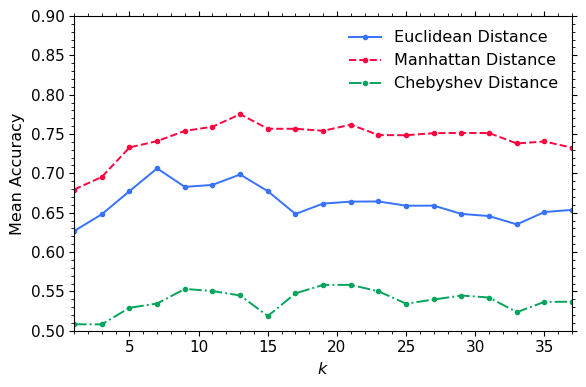

Mean accuracy scores for different k values and distance metrics (PCA features):


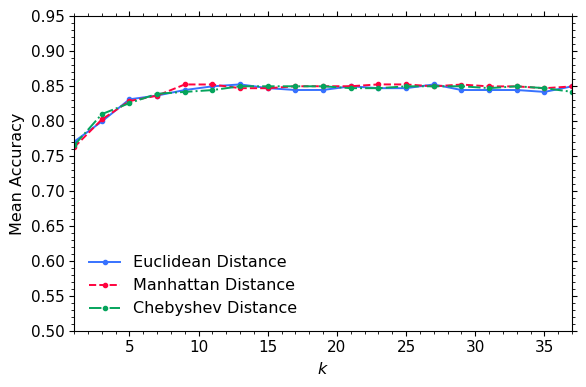

In [16]:
# === PCA before kNN or not? =======================================================================

# Extract feature columns
feature_columns = df_B_new.columns[df_B_new.columns != 'classification'].tolist()

# Perform PCA on the entire feature space
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_B_new[feature_columns])
n_pca = 2
pca = PCA(n_components=n_pca) 
features_pca = pca.fit_transform(features_scaled)

# Create a dataframe with the PCA features and the 'classification' column
pca_columns = [f"PC_{i+1}" for i in range(n_pca)]
df_pca = pd.DataFrame(data=features_pca, columns=pca_columns)
df_pca['classification'] = df_B_new['classification']

# Split full dataset and PCA dataset into rows with missing and non-missing 'classification' column
df_non_missing = df_B_new[df_B_new['classification'].notnull()]
df_missing = df_B_new[df_B_new['classification'].isnull()]
df_pca_non_missing = df_pca[df_pca['classification'].notnull()]
df_pca_missing = df_pca[df_pca['classification'].isnull()]

# Split data into features and labels and scale features
X_full = np.array(df_non_missing[feature_columns])
X_pca = np.array(df_pca_non_missing[pca_columns])
y_train = np.array(df_non_missing['classification'])

# Initialise StratifiedKFold with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed_football_number)

# Define a range of k values to test
k_list = list(range(1, 38, 2))

# Create empty lists for different distance metrics to store mean accuracy scores
mean_scores_euclidean = []
mean_scores_manhattan = []
mean_scores_chebyshev = []
mean_scores_euclidean_pca = []
mean_scores_manhattan_pca = []
mean_scores_chebyshev_pca = []

# Loop through each k value and perform cross-validation for kNN for different distance metrics
for k in k_list:
    # Initialise kNN classifiers with different distance metrics
    knn_euclidean = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn_manhattan = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn_chebyshev = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    # Perform cross-validation with on full dataset and PCA dataset
    scores_euclidean = cross_val_score(knn_euclidean, X_full, y_train, cv=skf, scoring='accuracy')
    scores_manhattan = cross_val_score(knn_manhattan, X_full, y_train, cv=skf, scoring='accuracy')
    scores_chebyshev = cross_val_score(knn_chebyshev, X_full, y_train, cv=skf, scoring='accuracy')
    scores_euclidean_pca = cross_val_score(knn_euclidean, X_pca, y_train, cv=skf, scoring='accuracy')
    scores_manhattan_pca = cross_val_score(knn_manhattan, X_pca, y_train, cv=skf, scoring='accuracy')
    scores_chebyshev_pca = cross_val_score(knn_chebyshev, X_pca, y_train, cv=skf, scoring='accuracy')
    # Calculate mean accuracy score for each case
    mean_score_euclidean = np.mean(scores_euclidean)
    mean_score_manhattan = np.mean(scores_manhattan)
    mean_score_chebyshev = np.mean(scores_chebyshev)
    mean_score_euclidean_pca = np.mean(scores_euclidean_pca)
    mean_score_manhattan_pca = np.mean(scores_manhattan_pca)
    mean_score_chebyshev_pca = np.mean(scores_chebyshev_pca)
    # Append mean score to mean_scores list
    mean_scores_euclidean.append(mean_score_euclidean)
    mean_scores_manhattan.append(mean_score_manhattan)
    mean_scores_chebyshev.append(mean_score_chebyshev)
    mean_scores_euclidean_pca.append(mean_score_euclidean_pca)
    mean_scores_manhattan_pca.append(mean_score_manhattan_pca)
    mean_scores_chebyshev_pca.append(mean_score_chebyshev_pca)

# Find the highest mean accuracy score
max_mean_score_euclidean = max(mean_scores_euclidean)
max_mean_score_manhattan = max(mean_scores_manhattan)
max_mean_score_chebyshev = max(mean_scores_chebyshev)
max_mean_score_euclidean_pca = max(mean_scores_euclidean_pca)
max_mean_score_manhattan_pca = max(mean_scores_manhattan_pca)
max_mean_score_chebyshev_pca = max(mean_scores_chebyshev_pca)

# Find the optimal k value for each distance metric
k_euclidean = k_list[mean_scores_euclidean.index(max_mean_score_euclidean)]
k_manhattan = k_list[mean_scores_manhattan.index(max_mean_score_manhattan)]
k_chebyshev = k_list[mean_scores_chebyshev.index(max_mean_score_chebyshev)]
k_euclidean_pca = k_list[mean_scores_euclidean_pca.index(max_mean_score_euclidean_pca)]
k_manhattan_pca = k_list[mean_scores_manhattan_pca.index(max_mean_score_manhattan_pca)]
k_chebyshev_pca = k_list[mean_scores_chebyshev_pca.index(max_mean_score_chebyshev_pca)]

# Find the optimal distance metric and the corresponding optimal k value
max_score_dictionary = {
    'euclidean': max_mean_score_euclidean, 
    'manhattan': max_mean_score_manhattan,
    'chebyshev': max_mean_score_chebyshev,
    'euclidean_pca': max_mean_score_euclidean_pca,
    'manhattan_pca': max_mean_score_manhattan_pca,
    'chebyshev_pca': max_mean_score_chebyshev_pca
}
metric_optimal = max(max_score_dictionary, key=max_score_dictionary.get)
score_optimal = max_score_dictionary[metric_optimal]
k_optimal = eval('k_' + metric_optimal)
print("Optimal distance metric: " + metric_optimal + ", Optimal k: " + str(k_optimal) + ", Accuracy: " + str(score_optimal))

# Plot the mean accuracy scores for different k values and distance metrics (full features)
print("Mean accuracy scores for different k values and distance metrics (full features):")
plt.figure()
plt.plot(k_list, mean_scores_euclidean, marker='.', linestyle='-', color=sd2022_blue, label='Euclidean Distance')
plt.plot(k_list, mean_scores_manhattan, marker='.', linestyle='--', color=sd2022_red, label='Manhattan Distance')
plt.plot(k_list, mean_scores_chebyshev, marker='.', linestyle='-.', color=sd2022_green, label='Chebyshev Distance')
plt.xlabel('$k$')
plt.ylabel('Mean Accuracy')
plt.ylim(bottom=0.5,top=0.9)
plt.legend()
plt.show()

# Plot the mean accuracy scores for different k values and distance metrics (PCA features)
print("Mean accuracy scores for different k values and distance metrics (PCA features):")
plt.figure()
plt.plot(k_list, mean_scores_euclidean_pca, marker='.', linestyle='-', color=sd2022_blue, label='Euclidean Distance')
plt.plot(k_list, mean_scores_manhattan_pca, marker='.', linestyle='--', color=sd2022_red, label='Manhattan Distance')
plt.plot(k_list, mean_scores_chebyshev_pca, marker='.', linestyle='-.', color=sd2022_green, label='Chebyshev Distance')
plt.xlabel('$k$')
plt.ylabel('Mean Accuracy')
plt.ylim(bottom=0.5,top=0.95)
plt.legend()
plt.show()

Euclidean Distance: Maximum Accuracy = 0.8994310099573257 with k = 3 and n_pca = 7
Manhattan Distance: Maximum Accuracy = 0.9073968705547653 with k = 3 and n_pca = 7
Chebyshev Distance: Maximum Accuracy = 0.8834992887624467 with k = 7 and n_pca = 5


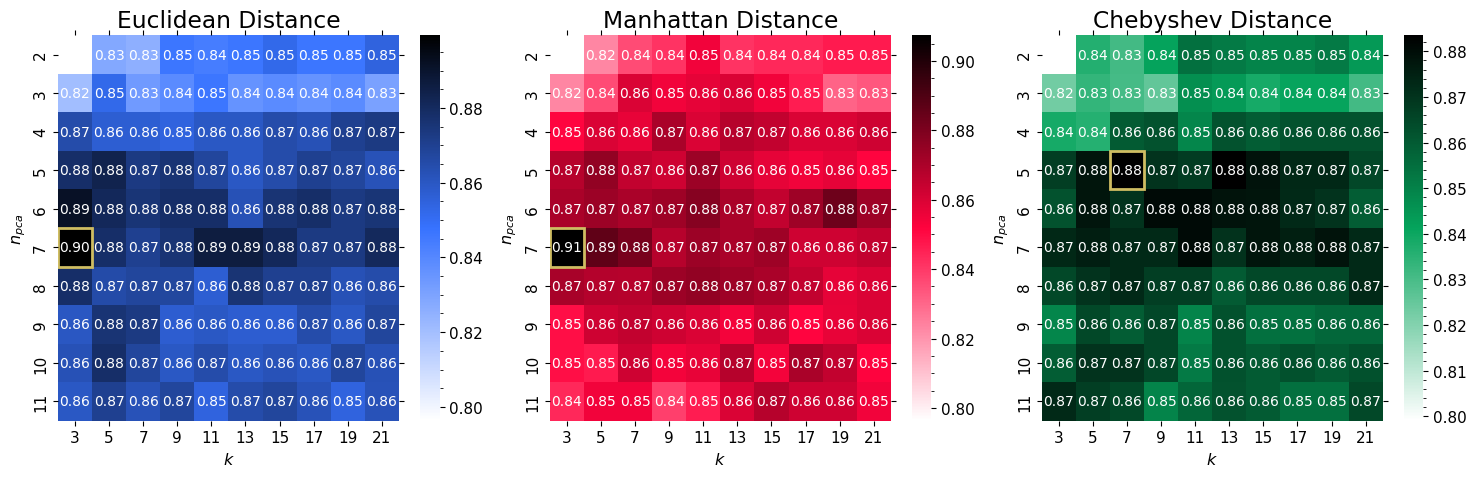

In [17]:
# === Hyperparameter Tuning for PCA and kNN label prediction =======================================

# Define a function to perform cross-validation and return the mean accuracy score
def accuracy_prediction(df, n_pca, k, metric, skf):
    # Extract feature columns
    feature_columns = df.columns[df.columns != 'classification'].tolist()
    # Perform PCA on the entire feature space
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df[feature_columns])
    pca = PCA(n_components=n_pca) 
    features_pca = pca.fit_transform(features_scaled)
    # Create a dataframe with the PCA features and the 'classification' column
    pca_columns = [f"PC_{i+1}" for i in range(n_pca)]
    df_pca = pd.DataFrame(data=features_pca, columns=pca_columns)
    df_pca['classification'] = df['classification']
    # Split full dataset and PCA dataset into rows with missing and non-missing 'classification' column
    df_non_missing = df_pca[df_pca['classification'].notnull()]
    df_missing = df_pca[df_pca['classification'].isnull()]
    # Split data into features and labels and scale features
    X_train = np.array(df_non_missing[pca_columns])
    y_train = np.array(df_non_missing['classification'])
    # Fit kNN classifier to training data
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
    knn.fit(X_train, y_train)
    # Perform cross-validation 
    scores = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
    mean_score = np.mean(scores)
    return mean_score

# Initialise StratifiedKFold with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed_fave_song)

# Define a range of n_pca values to test
n_pca_list = list(range(2, 12,1))

# Define a range of k values to test
k_list = list(range(3, 23,2))

# Initialise accuracy scores matrix for each distance metric
accuracy_matrix_euclidean = np.zeros((len(n_pca_list), len(k_list)))
accuracy_matrix_manhattan = np.zeros((len(n_pca_list), len(k_list)))
accuracy_matrix_chebyshev = np.zeros((len(n_pca_list), len(k_list)))

# Loop through n_pca values
for i, n_pca in enumerate(n_pca_list):
    # Loop through k values
    for j, k in enumerate(k_list):
        # Calculate accuracy for each combination of hyperparameters
        accuracy_euclidean = accuracy_prediction(df_B_new, n_pca, k, 'euclidean', skf)
        accuracy_manhattan = accuracy_prediction(df_B_new, n_pca, k, 'manhattan', skf)
        accuracy_chebyshev = accuracy_prediction(df_B_new, n_pca, k, 'chebyshev', skf)
        # Store accuracy in accuracy matrix
        accuracy_matrix_euclidean[i, j] = accuracy_euclidean
        accuracy_matrix_manhattan[i, j] = accuracy_manhattan
        accuracy_matrix_chebyshev[i, j] = accuracy_chebyshev

# Get indices of maximum accuracy values for each distance metric
max_index_euclidean = np.unravel_index(np.argmax(accuracy_matrix_euclidean), accuracy_matrix_euclidean.shape)
max_index_manhattan = np.unravel_index(np.argmax(accuracy_matrix_manhattan), accuracy_matrix_manhattan.shape)
max_index_chebyshev = np.unravel_index(np.argmax(accuracy_matrix_chebyshev), accuracy_matrix_chebyshev.shape)

# Get the corresponding k and n_pca values for each distance metric
max_k_euclidean, max_n_pca_euclidean = k_list[max_index_euclidean[1]], n_pca_list[max_index_euclidean[0]]
max_k_manhattan, max_n_pca_manhattan = k_list[max_index_manhattan[1]], n_pca_list[max_index_manhattan[0]]
max_k_chebyshev, max_n_pca_chebyshev = k_list[max_index_chebyshev[1]], n_pca_list[max_index_chebyshev[0]]

# Retrieve the maximum accuracy values for each distance metric
max_accuracy_euclidean = np.max(accuracy_matrix_euclidean)
max_accuracy_manhattan = np.max(accuracy_matrix_manhattan)
max_accuracy_chebyshev = np.max(accuracy_matrix_chebyshev)

# Print the maximum accuracy and corresponding k, n_pca values for each distance metric
print("Euclidean Distance: Maximum Accuracy =", max_accuracy_euclidean, "with k =", max_k_euclidean, "and n_pca =", max_n_pca_euclidean)
print("Manhattan Distance: Maximum Accuracy =", max_accuracy_manhattan, "with k =", max_k_manhattan, "and n_pca =", max_n_pca_manhattan)
print("Chebyshev Distance: Maximum Accuracy =", max_accuracy_chebyshev, "with k =", max_k_chebyshev, "and n_pca =", max_n_pca_chebyshev)

# Plot the accuracy matrix for each distance metric 
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

# Plot each heatmap on separate subplots
sns.heatmap(accuracy_matrix_euclidean, cmap=cmap_blue, ax=axes[0])
axes[0].set_title('Euclidean Distance')
sns.heatmap(accuracy_matrix_manhattan, cmap=cmap_red, ax=axes[1])
axes[1].set_title('Manhattan Distance')
sns.heatmap(accuracy_matrix_chebyshev, cmap=cmap_green, ax=axes[2])
axes[2].set_title('Chebyshev Distance')

# Set axis labels and tick labels
for ax in axes:
    ax.set_xlabel('$k$')
    ax.set_ylabel('$n_{pca}$')
    ax.set_xticklabels(k_list)
    ax.set_yticklabels(n_pca_list)
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.xaxis.set_minor_locator(plt.NullLocator())
    # ax.tick_params(axis='both', which='both', length=0)
    
# Annotations for Euclidean distance
for i in range(len(n_pca_list)):
    for j in range(len(k_list)):
        axes[0].text(j + 0.5, i + 0.5, f'{accuracy_matrix_euclidean[i][j]:.2f}',
                ha='center', va='center', color='white', fontsize =10)
# Annotations for Manhattan distance
for i in range(len(n_pca_list)):
    for j in range(len(k_list)):
        axes[1].text(j + 0.5, i + 0.5, f'{accuracy_matrix_manhattan[i][j]:.2f}',
                ha='center', va='center', color='white', fontsize=10)
# Annotations for Chebyshev distance
for i in range(len(n_pca_list)):
    for j in range(len(k_list)):
        axes[2].text(j + 0.5, i + 0.5, f'{accuracy_matrix_chebyshev[i][j]:.2f}',
                ha='center', va='center', color='white', fontsize=10)

# Annotate maximum accuracy values
rect_euclidean = Rectangle((max_index_euclidean[1], max_index_euclidean[0]), 1, 1, fill=False, edgecolor=sd2022_gold, linewidth=2)
rect_manhattan = Rectangle((max_index_manhattan[1], max_index_manhattan[0]), 1, 1, fill=False, edgecolor=sd2022_gold, linewidth=2)
rect_chebyshev = Rectangle((max_index_chebyshev[1], max_index_chebyshev[0]), 1, 1, fill=False, edgecolor=sd2022_gold, linewidth=2)
axes[0].add_patch(rect_euclidean)
axes[1].add_patch(rect_manhattan)
axes[2].add_patch(rect_chebyshev)

plt.tight_layout()
plt.show()

Model Accuracy: 0.9497354497354498
Classification Report:
              precision    recall  f1-score   support

         1.0       0.93      0.98      0.95       164
         2.0       0.97      0.95      0.96       149
         4.0       0.97      0.89      0.93        65

    accuracy                           0.95       378
   macro avg       0.95      0.94      0.95       378
weighted avg       0.95      0.95      0.95       378

Confusion Matrix:


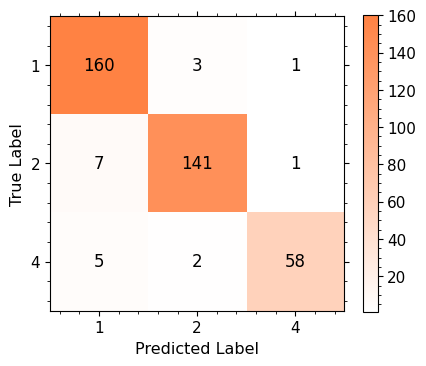

In [18]:
# === Predict classification labels using kNN for observations without missing labels ==============

# Set optimal hyperparameters
n_pca = 7
k = 3
metric = 'manhattan'

# Extract feature columns
feature_columns = df_B_new.columns[df_B_new.columns != 'classification'].tolist()

# Perform PCA on the entire feature space
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_B_new[feature_columns])
pca_optimal = PCA(n_components=n_pca) 
features_pca_optimal = pca_optimal.fit_transform(features_scaled)

# Create a dataframe with the PCA features and the classification column
pca_columns_optimal = [f"PC_{i+1}" for i in range(n_pca)]
df_pca_optimal = pd.DataFrame(data=features_pca_optimal, columns=pca_columns_optimal)
df_pca_optimal['classification'] = df_B_new['classification']

# Get rows with non-missing 'classification' column
df_pca_non_missing = df_pca_optimal[df_pca_optimal['classification'].notnull()]
df_non_missing = df_B_new[df_B_new['classification'].notnull()]

# Split data into features and labels and scale features
X_non_missing = np.array(df_pca_non_missing[pca_columns_optimal])
y_non_missing = np.array(df_pca_non_missing['classification'])

# Fit kNN classifier to non-missing data
knn_classifier = KNeighborsClassifier(n_neighbors=k, metric=metric)
knn_classifier.fit(X_non_missing, y_non_missing)

# Predict the classification of rows with non-missing 'classification' column
predictions_non_missing = knn_classifier.predict(X_non_missing)

# Calculate the prediction accuracy 
accuracy_non_missing = accuracy_score(y_non_missing, predictions_non_missing)
print("Model Accuracy: " + str(accuracy_non_missing))

# Generate classification report
classification_report_result = classification_report(y_non_missing, predictions_non_missing)
print("Classification Report:")
print(classification_report_result)

# Plot confusion matrix
confusion_matrix_result = confusion_matrix(y_non_missing, predictions_non_missing)
print("Confusion Matrix:")
plt.figure(figsize=(4.5, 4))
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=cmap_orange)
plt.colorbar(shrink=0.9)
tick_marks = np.arange(len(confusion_matrix_result))
custom_labels = [1, 2, 4]
tick_marks = np.arange(len(custom_labels))
plt.xticks(tick_marks, custom_labels)
plt.yticks(tick_marks, custom_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Add annotations
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result)):
        plt.text(j, i, str(confusion_matrix_result[i][j]), ha='center', va='center', color='black', fontsize=12)


In [19]:
# === Predict classification labels using kNN for observations with missing labels =================

# Get rows with non-missing 'classification' column
df_missing = df_B_new[df_B_new['classification'].isnull()]
df_pca_missing = df_pca_optimal[df_pca_optimal['classification'].isnull()]

# Get features from 'df_missing' 
X_missing = np.array(df_pca_missing[pca_columns_optimal])

# Predict the classification of rows with missing 'classification' column
predictions_missing = knn_classifier.predict(X_missing)
df_missing.loc[:, 'classification'] = predictions_missing

# Combine the rows with missing 'classification' column and the rows with non-missing 'classification' column
df_B_final = pd.concat([df_missing, df_non_missing])

print("Predictions for original missing rows:")
print(predictions_missing[:20])

print("Predictions for missing rows from duplicates in Question 1 (b):")
print(predictions_missing[-10:])

Predictions for original missing rows:
[1. 2. 1. 2. 4. 4. 2. 1. 2. 1. 2. 1. 1. 2. 1. 1. 2. 2. 2. 1.]
Predictions for missing rows from duplicates in Question 1 (b):
[2. 4. 1. 2. 1. 1. 2. 2. 1. 1.]


In [20]:
# === Label frequencies of final dataset ===========================================================

# Get the absolute and relative frequency of labels ('classification' column)
df_final_class_counts = df_B_final['classification'].value_counts(dropna=False).reset_index()
df_final_class_counts['relative_count'] = (df_final_class_counts['count'] / len(df_B_final)).round(3)

# Display updated label frequencies using tabulate
print("Label frequencies (updated):\n")
print(tabulate(df_final_class_counts, headers = ['Label', 'Frequency', 'Relative Frequency'], showindex=False))
print("Total number of rows in the final dataset: ")
print(len(df_B_final))


Label frequencies (updated):

  Label    Frequency    Relative Frequency
-------  -----------  --------------------
      1          178                 0.436
      2          162                 0.397
      4           68                 0.167
Total number of rows in the final dataset: 
408
